In [2]:
# Mount Google Drive first so data saves permanently
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!ls /content/drive/MyDrive/synthea_run/output/csv

allergies.csv		 encounters.csv       patients.csv
careplans.csv		 imaging_studies.csv  payers.csv
claims.csv		 immunizations.csv    payer_transitions.csv
claims_transactions.csv  medications.csv      procedures.csv
conditions.csv		 observations.csv     providers.csv
devices.csv		 organizations.csv    supplies.csv


In [4]:
import pandas as pd

# Set the base path where the CSVs are saved
path = "/content/drive/MyDrive/synthea_run/output/csv/"

# Load a few core tables
patients = pd.read_csv(path + "patients.csv")
encounters = pd.read_csv(path + "encounters.csv")
conditions = pd.read_csv(path + "conditions.csv")

# Print basic info
print("Patients:", patients.shape)
print("Encounters:", encounters.shape)
print("Conditions:", conditions.shape)

# Display first few rows
patients.head()

Patients: (22025, 28)
Encounters: (1320125, 15)
Conditions: (805490, 7)


,Id,BIRTHDATE,DEATHDATE,SSN,DRIVERS,PASSPORT,PREFIX,FIRST,MIDDLE,LAST,...,CITY,STATE,COUNTY,FIPS,ZIP,LAT,LON,HEALTHCARE_EXPENSES,HEALTHCARE_COVERAGE,INCOME
0,f173c55d-26fa-40a7-4d3d-a0a77af219ec,2024-08-12,NaN,999-75-4930,NaN,NaN,NaN,Ashanti808,NaN,Jacobs452,...,Leominster,Massachusetts,Worcester County,25027.0,1420,42.603102,-71.795391,4724.95,0.00,40198
1,54b46b82-ccd2-47e3-b6ba-54c12a0f5233,1983-08-30,NaN,999-68-3161,S99932882,X81531722X,Mr.,Noah480,Renaldo199,Langosh790,...,Milford,Massachusetts,Worcester County,25027.0,1757,42.176644,-71.568395,76908.16,44985.15,111252
2,592f1cac-2d62-d178-d6d6-fbdc682f5974,1965-10-28,NaN,999-37-5820,S99939579,X48365034X,Ms.,Marcela739,NaN,Greenfelder433,...,Brockton,Massachusetts,Plymouth County,25023.0,2351,42.131652,-71.052953,270759.66,846175.28,195656
3,12da762c-7352-a8fc-0312-c51dfc2152dd,2009-04-28,NaN,999-85-1913,S99989135,NaN,NaN,Leon728,Janelle257,Goldner995,...,Dartmouth,Massachusetts,Bristol County,NaN,0,41.560245,-71.002488,23968.15,23862.14,141699
4,a1e5ea03-7d36-87ff-e2d9-c2db594b9de6,1997-01-04,NaN,999-20-2749,S99916462,X87817056X,Mrs.,Margaret865,Catherine271,Cartwright189,...,Boston,Massachusetts,Suffolk County,25025.0,2210,42.379165,-71.125928,199276.13,405946.09,29246


In [5]:
# Number of unique patients
patients['Id'].nunique()

# Number of encounters per patient (first 5)
enc_per_patient = encounters.groupby('PATIENT').size().head()
print(enc_per_patient)

# Check a few columns
print(patients.columns)
print(encounters.columns)


PATIENT
00010e8f-590e-3608-5307-0c075d7b83b6     27
00037657-224c-8a27-8e00-252779d41cc3     36
0004e2d2-969c-2b8e-b5c3-b1cc51eac06a     72
00070edc-4a3d-6dcb-de91-39d828ea23c5    544
00097b68-2bce-3e49-4b50-c28f44deed0b    302
dtype: int64
Index(['Id', 'BIRTHDATE', 'DEATHDATE', 'SSN', 'DRIVERS', 'PASSPORT', 'PREFIX',
       'FIRST', 'MIDDLE', 'LAST', 'SUFFIX', 'MAIDEN', 'MARITAL', 'RACE',
       'ETHNICITY', 'GENDER', 'BIRTHPLACE', 'ADDRESS', 'CITY', 'STATE',
       'COUNTY', 'FIPS', 'ZIP', 'LAT', 'LON', 'HEALTHCARE_EXPENSES',
       'HEALTHCARE_COVERAGE', 'INCOME'],
      dtype='object')
Index(['Id', 'START', 'STOP', 'PATIENT', 'ORGANIZATION', 'PROVIDER', 'PAYER',
       'ENCOUNTERCLASS', 'CODE', 'DESCRIPTION', 'BASE_ENCOUNTER_COST',
       'TOTAL_CLAIM_COST', 'PAYER_COVERAGE', 'REASONCODE',
       'REASONDESCRIPTION'],
      dtype='object')


In [6]:
### Creating features from Encounters table

import numpy as np
import pandas as pd # Import pandas here as well

# Prep
enc = encounters.copy()

# Ensure datetimes
enc['START'] = pd.to_datetime(enc['START'])
enc['STOP']  = pd.to_datetime(enc['STOP'])

# Sort once (by patient + time)
enc = enc.sort_values(['PATIENT','START']).reset_index(drop=True)

# Filter for inpatient encounters (hospital admissions/discharges) and define 'inpatient'
inpatient = enc[enc['ENCOUNTERCLASS'] == 'inpatient'].copy()

# Convert START and STOP times to datetime for the new inpatient dataframe as well
inpatient['START'] = pd.to_datetime(inpatient['START'])
inpatient['STOP']  = pd.to_datetime(inpatient['STOP'])

# Create the “readmission within 30 days” label on the inpatient dataframe
inpatient = inpatient.sort_values(['PATIENT', 'START'])
inpatient['NEXT_START'] = inpatient.groupby('PATIENT')['START'].shift(-1)
inpatient['READMIT_30D'] = (
    (inpatient['NEXT_START'] - inpatient['STOP']).dt.days <= 30
) & (
    (inpatient['NEXT_START'] - inpatient['STOP']).dt.days > 0
)
inpatient['READMIT_30D'] = inpatient['READMIT_30D'].fillna(False).astype(int)


# 1) Per-encounter basics
# Length of stay (days), clipped at 0
enc['LOS_days'] = (enc['STOP'] - enc['START']).dt.total_seconds()/86400
enc['LOS_days'] = enc['LOS_days'].clip(lower=0)

# Admission timing features
enc['admit_hour'] = enc['START'].dt.hour
enc['admit_dow']  = enc['START'].dt.dayofweek  # 0=Mon
enc['is_weekend'] = enc['admit_dow'].isin([5,6]).astype(int)
enc['is_night']   = enc['admit_hour'].between(22,23) | enc['admit_hour'].between(0,6)
enc['is_night']   = enc['is_night'].astype(int)

# Calendar context
enc['admit_month']   = enc['START'].dt.month
enc['admit_quarter'] = enc['START'].dt.quarter
enc['admit_season']  = pd.cut(enc['START'].dt.month,
                              bins=[0,3,6,9,12],
                              labels=['Winter','Spring','Summer','Fall'],
                              right=True)

# 2) Prior encounter gap (time since last discharge)
# Last STOP per patient (shifted so it’s prior)
enc['prev_stop'] = enc.groupby('PATIENT')['STOP'].shift(1)
enc['gap_since_prev_discharge_days'] = (enc['START'] - enc['prev_stop']).dt.total_seconds()/86400

# 3) Rolling prior-year utilization (per patient, time-based window)
## Computing counts in the past 365 days (excluding current encounter) for ER, inpatient, outpatient, total; plus prior mean LOS and prior total cost
# Indicators for classes
enc['is_ER']        = (enc['ENCOUNTERCLASS'] == 'emergency').astype(int)
enc['is_inpatient'] = (enc['ENCOUNTERCLASS'] == 'inpatient').astype(int)
enc['is_outpatient']= (enc['ENCOUNTERCLASS'] == 'outpatient').astype(int)

# For time-based rolling per patient, set START as index within each group
def add_rolling_features(g):
    g = g.set_index('START')  # time index REQUIRED for time-based rolling window
    # Shift by 1 to EXCLUDE current encounter from "prior" window
    prior = g.shift(1)

    # Rolling 365-day windows
    win = prior.rolling('365D')

    g['prior365_total_enc']   = win['Id'].count()                           # all encounters
    g['prior365_ER']          = win['is_ER'].sum()
    g['prior365_inpatient']   = win['is_inpatient'].sum()
    g['prior365_outpatient']  = win['is_outpatient'].sum()
    g['prior365_mean_LOS']    = win['LOS_days'].mean() if 'LOS_days' in g.columns else np.nan

    # Use TOTAL_CLAIM_COST if present; else fallback to BASE_ENCOUNTER_COST
    cost_col = 'TOTAL_CLAIM_COST' if 'TOTAL_CLAIM_COST' in g.columns else \
               ('BASE_ENCOUNTER_COST' if 'BASE_ENCOUNTER_COST' in g.columns else None)
    if cost_col:
        g['prior365_total_cost'] = win[cost_col].sum()
    else:
        g['prior365_total_cost'] = np.nan


    return g.reset_index()

enc = enc.groupby('PATIENT', group_keys=False).apply(add_rolling_features)

# 4) Previous encounter class (categorical "context")
# enc is sorted by patient and time first
enc = enc.sort_values(['PATIENT','START']).reset_index(drop=True)

# previous encounter class per patient
enc['prev_class'] = enc.groupby('PATIENT')['ENCOUNTERCLASS'].shift(1)

# Keep just inpatient rows as your "index encounters" and include READMIT_30D
inpatient_idx = enc[enc['ENCOUNTERCLASS']=='inpatient'].copy()
# Merge READMIT_30D from the original inpatient dataframe
inpatient_idx = inpatient_idx.merge(inpatient[['Id', 'READMIT_30D']], left_on='Id', right_on='Id', how='left')

/tmp/ipython-input-3639280212.py:92: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  enc = enc.groupby('PATIENT', group_keys=False).apply(add_rolling_features)


In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Select the top predictors identified in the logistic regression model
top_predictors = [
    'prior365_inpatient',
    'prior365_total_cost',
    'prior365_outpatient',
    'AGE',
    'prior365_ER',
    'LOS_days',
    'gap_since_prev_discharge_days' # Also include LOS and gap as they are important
]

# Merge AGE from patients dataframe into inpatient_idx
# Ensure 'Id' is the correct join key in patients and 'PATIENT' in inpatient_idx
# Check if 'AGE' is calculated in patients. If not, calculate it.
if 'AGE' not in patients.columns:
  patients['BIRTHDATE'] = pd.to_datetime(patients['BIRTHDATE'])
  patients['AGE'] = (pd.Timestamp('today') - patients['BIRTHDATE']).dt.days / 365

plot_df = inpatient_idx.merge(patients[['Id', 'AGE']], left_on='PATIENT', right_on='Id', how='left')

# Drop the redundant 'Id' column after merging
plot_df = plot_df.drop(columns='Id', errors='ignore').copy()


# Add the target variable for plotting (it should already be in inpatient_idx after the previous merge)
# plot_df = inpatient_idx[top_predictors + ['READMIT_30D']].copy() # This line is no longer needed as inpatient_idx already has READMIT_30D and we merged AGE

# Convert the target variable to string for better plotting labels
plot_df['READMIT_30D'] = plot_df['READMIT_30D'].astype(str)



In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, roc_curve, precision_recall_curve
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

# --- 1️⃣ Select features ---
# Merge patient info into inpatient_idx which has engineered features
model_df = inpatient_idx.merge(patients[['Id','AGE','GENDER','RACE','ETHNICITY']],
                               left_on='PATIENT', right_on='Id', how='left')

# Drop the redundant 'Id' column from the merge
model_df = model_df.drop(columns='Id', errors='ignore').copy()

# choose predictor columns
predictors = [
    # Demographics
    'AGE', 'GENDER', 'RACE', 'ETHNICITY',
    # Encounter-based features
    'LOS_days', 'gap_since_prev_discharge_days',
    'prior365_total_enc', 'prior365_ER', 'prior365_inpatient',
    'prior365_outpatient',
    # optional extras
    'is_weekend', 'is_night', 'admit_hour', 'admit_dow',
    'PATIENT' # Include PATIENT for grouping before splitting
]

# Drop rows with missing target or key features
model_df = model_df.dropna(subset=[col for col in predictors if col != 'PATIENT'] + ['READMIT_30D'])

Train encounters: 17529 | Test encounters: 3982
Unique patients (train): 6022 | Unique patients (test): 1506

Classification Report:
              precision    recall  f1-score   support

           0      0.973     0.833     0.897      3335
           1      0.505     0.879     0.642       647

    accuracy                          0.841      3982
   macro avg      0.739     0.856     0.770      3982
weighted avg      0.897     0.841     0.856      3982

AUC: 0.910


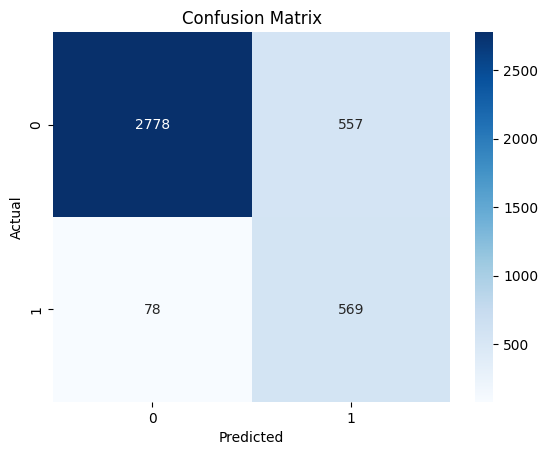

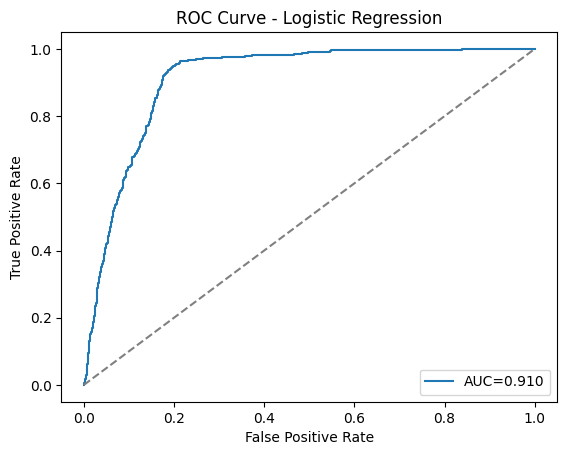


Top predictors by coefficient:
                  Feature  Coefficient  Odds_Ratio
5      prior365_inpatient     0.891834    2.439600
7     prior365_total_cost     0.572425    1.772559
6     prior365_outpatient     0.351716    1.421505
12               GENDER_M     0.326546    1.386172
0                     AGE     0.258346    1.294786
4             prior365_ER     0.156693    1.169637
18  ETHNICITY_nonhispanic     0.081924    1.085373
16             RACE_other     0.067254    1.069567
15            RACE_native     0.064633    1.066767
11              admit_dow     0.036353    1.037022


In [13]:

# Define X and y
X = model_df[predictors]
y = model_df['READMIT_30D']
groups = model_df['PATIENT']  # for grouped splitting

# --- 2️⃣ Train/test split grouped by patient ---
from sklearn.model_selection import GroupShuffleSplit

splitter = GroupShuffleSplit(test_size=0.2, n_splits=1, random_state=42)
for train_idx, test_idx in splitter.split(X, y, groups):
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]
    train_groups = groups.iloc[train_idx] # Store groups for printing
    test_groups = groups.iloc[test_idx]   # Store groups for printing


print(f"Train encounters: {X_train.shape[0]} | Test encounters: {X_test.shape[0]}")
print(f"Unique patients (train): {train_groups.nunique()} | Unique patients (test): {test_groups.nunique()}")

# Drop the PATIENT column before encoding
X_train = X_train.drop(columns='PATIENT')
X_test  = X_test.drop(columns='PATIENT')


# --- 3️⃣ Encode categorical vars ---
X_train = pd.get_dummies(X_train, columns=['GENDER', 'RACE', 'ETHNICITY'], drop_first=True)
X_test  = pd.get_dummies(X_test, columns=['GENDER', 'RACE', 'ETHNICITY'], drop_first=True)

# align columns in case train/test differ slightly
X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

# Identify numerical columns after one-hot encoding
numerical_cols = X_train.select_dtypes(include=np.number).columns.tolist()
# Exclude binary columns created by get_dummies if necessary, though drop_first=True helps
# A more robust way might be to track original numerical columns and scale them before get_dummies,
# but for this case, we'll scale all numeric columns after encoding, excluding potential binary dummies if needed.
# Let's assume all non-dummy columns are the original numerical ones + some binary flags.
# A safer approach would be to identify original numerical columns:
original_numerical_cols = ['AGE', 'LOS_days', 'gap_since_prev_discharge_days',
                           'prior365_total_enc', 'prior365_ER', 'prior365_inpatient',
                           'prior365_outpatient', 'prior365_total_cost',
                           'admit_hour', 'admit_dow']

# Filter for which of these are actually in X_train after dropping PATIENT and before get_dummies
# This approach is flawed because get_dummies has already run.
# Let's identify numerical columns by type *after* get_dummies and exclude obvious binary ones if needed.
# A simpler approach here is to just scale all numeric columns since logistic regression handles binary well.
numerical_cols = X_train.select_dtypes(include=np.number).columns.tolist()


# --- 4️⃣ Scale numerical features ---
scaler = StandardScaler()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])


# --- 5️⃣ Fit logistic regression ---
log_reg = LogisticRegression(max_iter=1000, class_weight='balanced', solver='lbfgs') # Increased max_iter
log_reg.fit(X_train, y_train)

# --- 6️⃣ Evaluate ---
y_pred = log_reg.predict(X_test)
y_prob = log_reg.predict_proba(X_test)[:,1]

print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=3))

print(f"AUC: {roc_auc_score(y_test, y_prob):.3f}")

# --- 7️⃣ Confusion matrix ---
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# --- 8️⃣ ROC Curve ---
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label=f"AUC={roc_auc_score(y_test, y_prob):.3f}")
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.legend()
plt.show()

# --- 9️⃣ Feature importance ---
coef_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': log_reg.coef_[0]
}).sort_values(by='Coefficient', ascending=False)

coef_df['Odds_Ratio'] = np.exp(coef_df['Coefficient'])
print("\nTop predictors by coefficient:")
print(coef_df.head(10))

In [17]:
from sklearn.model_selection import GroupKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score
import numpy as np

# Assuming model_df, predictors, y, and groups are already defined from the previous steps
# (model_df contains the merged data including patient demographics and engineered features,
#  y is the target variable READMIT_30D, and groups is the PATIENT column)

# Define X and y (excluding the PATIENT column for the model training)
X = model_df[predictors].drop(columns='PATIENT')
y = model_df['READMIT_30D']
groups = model_df['PATIENT']

# Encode categorical variables and align columns
X = pd.get_dummies(X, columns=['GENDER', 'RACE', 'ETHNICITY'], drop_first=True)

# Get the list of numerical columns after one-hot encoding
numerical_cols = X.select_dtypes(include=np.number).columns.tolist()

# Scale numerical features
scaler = StandardScaler()
X[numerical_cols] = scaler.fit_transform(X[numerical_cols])


# Initialize GroupKFold
# You can adjust the number of splits (n_splits)
n_splits = 5
group_kfold = GroupKFold(n_splits=n_splits)

In [19]:
# Lists to store results from each fold
classification_reports = []
roc_auc_scores = []

# Perform cross-validation
print(f"Performing {n_splits}-fold Group Cross-Validation...")
for fold, (train_index, test_index) in enumerate(group_kfold.split(X, y, groups)):
    print(f"\n--- Fold {fold+1}/{n_splits} ---")
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Re-align columns just in case (important if some categories only appear in train or test)
    X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

    # Initialize and train the logistic regression model
    # Using balanced class weight as before
    log_reg = LogisticRegression(max_iter=1000, class_weight='balanced', solver='lbfgs')
    log_reg.fit(X_train, y_train) # Corrected: fit on y_train, not y_test

    # Evaluate the model on the test fold
    y_pred = log_reg.predict(X_test)
    y_prob = log_reg.predict_proba(X_test)[:, 1]

    # Store evaluation metrics
    report = classification_report(y_test, y_pred, digits=3, output_dict=True)
    classification_reports.append(report)
    roc_auc = roc_auc_score(y_test, y_prob)
    roc_auc_scores.append(roc_auc)

    print("Classification Report:")
    print(classification_report(y_test, y_pred, digits=3))
    print(f"AUC: {roc_auc:.3f}")




Performing 5-fold Group Cross-Validation...

--- Fold 1/5 ---
Classification Report:
              precision    recall  f1-score   support

           0      0.964     0.798     0.873      3578
           1      0.460     0.851     0.597       725

    accuracy                          0.807      4303
   macro avg      0.712     0.824     0.735      4303
weighted avg      0.879     0.807     0.826      4303

AUC: 0.868

--- Fold 2/5 ---
Classification Report:
              precision    recall  f1-score   support

           0      0.952     0.802     0.871      3500
           1      0.488     0.823     0.613       802

    accuracy                          0.806      4302
   macro avg      0.720     0.813     0.742      4302
weighted avg      0.865     0.806     0.823      4302

AUC: 0.884

--- Fold 3/5 ---
Classification Report:
              precision    recall  f1-score   support

           0      0.954     0.814     0.878      3491
           1      0.509     0.832     0.632     

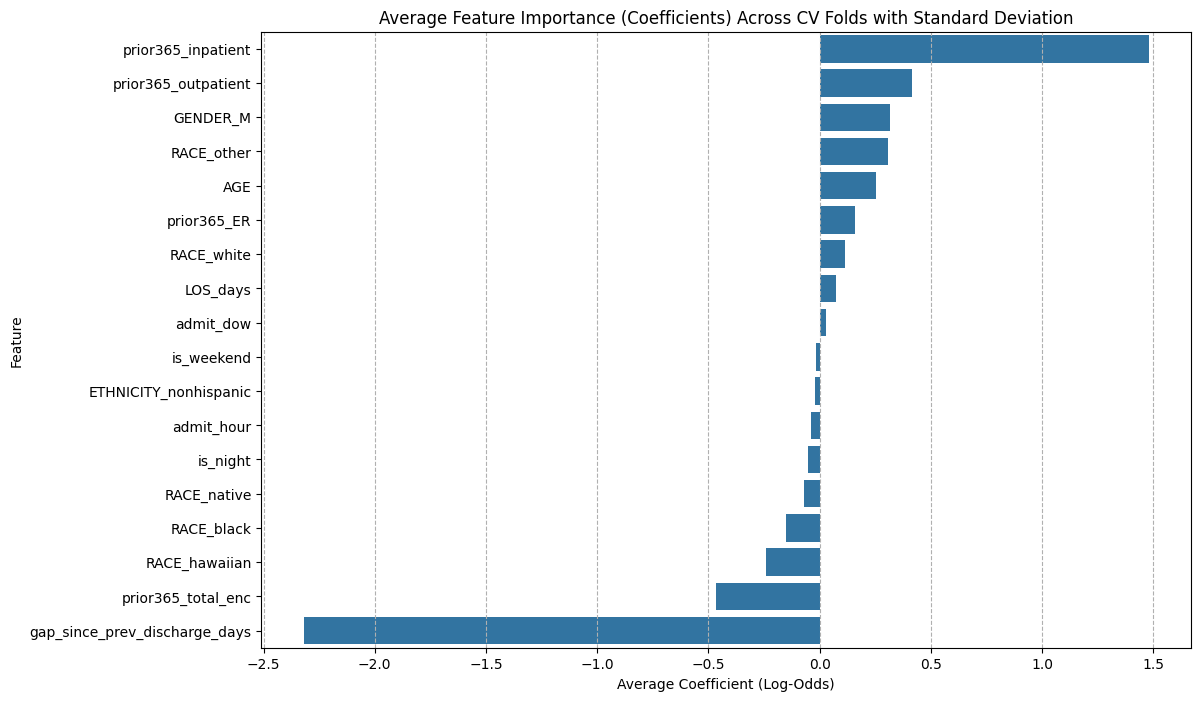

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Assuming feature_importance_df is available from the previous step
# (where average_coefs, std_coefs, and feature names were calculated and stored in cell acf13ebc)

# Ensure the dataframe is sorted by average coefficient for better visualization
feature_importance_df_sorted = feature_importance_df.sort_values(by='Average_Coefficient', ascending=False).reset_index(drop=True)

plt.figure(figsize=(12, 8))
sns.barplot(x='Average_Coefficient', y='Feature', data=feature_importance_df_sorted, errorbar='sd', capsize=4)
plt.title('Average Feature Importance (Coefficients) Across CV Folds with Standard Deviation')
plt.xlabel('Average Coefficient (Log-Odds)')
plt.ylabel('Feature')
plt.grid(axis='x', linestyle='--')
plt.show()

In [23]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GroupKFold # Import GroupKFold

# Assuming X (scaled and one-hot encoded features), y, and groups are defined from previous steps

# Initialize GroupKFold (re-initialize in this cell for clarity)
n_splits = 5
group_kfold = GroupKFold(n_splits=n_splits)

# List to store coefficients from each fold
coefs = []

# Re-run the cross-validation loop to collect coefficients
print(f"Collecting coefficients from {n_splits}-fold Group Cross-Validation...")
for fold, (train_index, test_index) in enumerate(group_kfold.split(X, y, groups)):
    # print(f"\n--- Fold {fold+1}/{n_splits} ---") # Optional: print fold progress
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Re-align columns just in case
    X_train, X_test = X_train.align(X_test, join='left', axis=1, fill_value=0)

    # Initialize and train the logistic regression model
    log_reg = LogisticRegression(max_iter=1000, class_weight='balanced', solver='lbfgs')
    log_reg.fit(X_train, y_train)

    # Store the coefficients for this fold
    coefs.append(log_reg.coef_[0])

# Convert the list of coefficients to a NumPy array for easier calculation
coefs_array = np.array(coefs)

# Calculate the average coefficient and standard deviation across folds
average_coefs = np.mean(coefs_array, axis=0)
std_coefs = np.std(coefs_array, axis=0)

# Create a DataFrame to display the results
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Average_Coefficient': average_coefs,
    'Std_Coefficient': std_coefs
})

# Calculate average Odds Ratio
feature_importance_df['Average_Odds_Ratio'] = np.exp(feature_importance_df['Average_Coefficient'])


# Sort by the absolute value of the average coefficient to see most important features
feature_importance_df['Abs_Avg_Coefficient'] = np.abs(feature_importance_df['Average_Coefficient'])
feature_importance_df = feature_importance_df.sort_values(by='Abs_Avg_Coefficient', ascending=False).drop(columns='Abs_Avg_Coefficient')


print("\nAverage Feature Importance (Coefficients) Across CV Folds:")
display(feature_importance_df)


Average Feature Importance (Coefficients) Across CV Folds:


,Feature,Average_Coefficient,Std_Coefficient,Average_Odds_Ratio
2,gap_since_prev_discharge_days,-2.320024,0.937446,0.098271
5,prior365_inpatient,1.480587,0.021474,4.395524
3,prior365_total_enc,-0.463755,0.032625,0.628918
6,prior365_outpatient,0.413557,0.030532,1.512188
11,GENDER_M,0.317111,0.086442,1.373155
15,RACE_other,0.308872,0.188715,1.361887
0,AGE,0.253324,0.020766,1.288300
13,RACE_hawaiian,-0.241253,0.280626,0.785643
4,prior365_ER,0.160627,0.011631,1.174247
12,RACE_black,-0.151357,0.258477,0.859541


In [21]:
# Calculate and print average metrics across all folds
print(f"\n--- Average Metrics Across {n_splits} Folds ---")

# Average classification report metrics
avg_report = {}
for metric in ['precision', 'recall', 'f1-score', 'support']:
    avg_report[metric] = {}
    for label in ['0', '1', 'accuracy', 'macro avg', 'weighted avg']:
        values = []
        for r in classification_reports:
            if label == 'accuracy':
                # Accuracy is a direct key in the report dictionary
                values.append(r.get('accuracy', np.nan))
            elif label in ['macro avg', 'weighted avg'] and metric in r.get(label, {}):
                 # Macro and weighted averages are nested dictionaries
                 values.append(r[label][metric])
            elif label in ['0', '1'] and metric in r.get(label, {}):
                 # Class-specific metrics are also nested dictionaries
                 values.append(r[label][metric])
            else:
                 values.append(np.nan) # Append NaN if the metric/label combination is not found


        # For 'support', sum instead of average for class-specific support
        if metric == 'support' and label in ['0', '1']:
             avg_report[metric][label] = np.nansum(values)
        elif metric != 'support' or label in ['accuracy', 'macro avg', 'weighted avg']:
             # Average other metrics, including accuracy, macro/weighted support
             avg_report[metric][label] = np.nanmean(values)


# Format and print average report
print("Average Classification Report:")
# Print header
print(f"{'':<10}{'precision':<10}{'recall':<10}{'f1-score':<10}{'support':<10}")
for label in ['0', '1', 'accuracy', 'macro avg', 'weighted avg']:
    # Ensure the label exists in the averaged report before trying to print
    if label in avg_report.get('precision', {}):
         print(f"{label:<10}{avg_report['precision'].get(label, np.nan):<10.3f}{avg_report['recall'].get(label, np.nan):<10.3f}{avg_report['f1-score'].get(label, np.nan):<10.3f}{avg_report['support'].get(label, np.nan):<10.0f}")
    elif label == 'accuracy' and 'accuracy' in avg_report.get('precision', {}): # Handle accuracy separately as it's not a nested dict in the original report
         print(f"{label:<10}{np.nan:<10.3f}{np.nan:<10.3f}{avg_report['f1-score'].get(label, np.nan):<10.3f}{avg_report['support'].get(label, np.nan):<10.0f}") # Only f1-score and support are meaningful for average accuracy



# Average AUC
avg_auc = np.mean(roc_auc_scores)
print(f"\nAverage AUC: {avg_auc:.3f}")

Average Classification Report:
          precision recall    f1-score  support   
0         0.960     0.801     0.873     17670     
1         0.480     0.847     0.613     3841      
accuracy  0.809     0.809     0.809     1         
macro avg 0.720     0.824     0.743     4302      
weighted avg0.875     0.809     0.827     4302      

Average AUC: 0.880


**Results:**
Based on the logistic regression model trained and evaluated using cross-validation, the results indicate a promising ability to predict 30-day hospital readmissions. The model achieved an average AUC of approximately 0.880 across the folds, suggesting good overall discriminatory power. While the model demonstrates high recall for the readmitted class (correctly identifying a significant portion of patients who were readmitted), its precision for this class is lower, indicating a notable number of false positives (predicting readmission when it didn't occur).

The feature importance analysis revealed that a patient's prior healthcare utilization (specifically, the number of prior inpatient and outpatient encounters and total costs in the past year), age, and the gap since their previous discharge are among the most influential predictors of readmission risk. Understanding these key drivers and the model's performance characteristics can inform targeted interventions to reduce readmissions and potentially refine the predictive model further.
